In [ ]:
# Download and extract geneformer model
!wget 'https://www.dropbox.com/scl/fi/4edmbf7fik0q8kzyq2pef/fine_tuned_geneformer.tar.gz?rlkey=v0ux8v9a3qe8il6o7bowxep8c&st=6ar0ptjg&dl=0' -O fine_tuned_geneformer.tar.gz
!tar -xzf fine_tuned_geneformer.tar.gz



# Download and extract pbmc data

!mkdir -p data
!wget -nv -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/pbmc3k_filtered_gene_bc_matrices.tar.gz -C data/

# Dowload gene list
! wget 'https://www.dropbox.com/scl/fi/brauikmesjfworl67cxov/cpdb_genelist.csv?rlkey=55ankib03njbf9tkci8tgzqc6&st=ezcv94sg&dl=0' -O cpdb_genelist.csv

import warnings

warnings.filterwarnings("ignore")

import json
import os

#import cellxgene_census
import datasets
import numpy as np
import scanpy as sc
from geneformer import DataCollatorForCellClassification
from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from transformers import BertForSequenceClassification, Trainer

from torch import set_float32_matmul_precision
set_float32_matmul_precision('medium')

adata = sc.read_10x_mtx("data/filtered_gene_bc_matrices/hg19/", var_names="gene_ids")
adata.var["ensembl_id"] = adata.var.index
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))

h5ad_dir = "./data/h5ad/"

if not os.path.exists(h5ad_dir):
    os.makedirs(h5ad_dir)

adata.write(h5ad_dir + "pbmcs.h5ad")

token_dir = "data/tokenized_data/"

if not os.path.exists(token_dir):
    os.makedirs(token_dir)

tokenizer = TranscriptomeTokenizer(custom_attr_name_dict={"joinid": "joinid"})
tokenizer.tokenize_data(
    data_directory=h5ad_dir,
    output_directory=token_dir,
    output_prefix="pbmc",
    file_format="h5ad",
)

model_dir = "./fine_tuned_geneformer/"
label_mapping_dict_file = os.path.join(model_dir, "label_to_cell_subclass.json")

with open(label_mapping_dict_file) as fp:
    label_mapping_dict = json.load(fp)

for k in list(label_mapping_dict.keys())[:5]:
    print(k, ': ', label_mapping_dict[k])

dataset = datasets.load_from_disk(token_dir + "pbmc.dataset")
dataset

dataset
dataset = dataset.add_column("label", [0] * len(dataset))

# reload pretrained model
model = BertForSequenceClassification.from_pretrained(model_dir)
# create the trainer
trainer = Trainer(model=model, data_collator=DataCollatorForCellClassification())
# use trainer
predictions = trainer.predict(dataset)

predicted_label_ids = np.argmax(predictions.predictions, axis=1)
predicted_logits = [predictions.predictions[i][predicted_label_ids[i]] for i in range(len(predicted_label_ids))]
predicted_labels = [label_mapping_dict[str(i)] for i in predicted_label_ids]

adata.obs["predicted_cell_subclass"] = predicted_labels
adata.obs["predicted_cell_subclass_probability"] = np.exp(predicted_logits) / (1 + np.exp(predicted_logits))

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

sc.tl.leiden(adata)
original_cell_types = [
    "CD4-positive, alpha-beta T cell (1)",
    "CD4-positive, alpha-beta T cell (2)",
    "CD14-positive, monocyte",
    "B cell (1)",
    "CD8-positive, alpha-beta T cell",
    "FCGR3A-positive, monocyte",
    "natural killer cell",
    "dendritic cell",
    "megakaryocyte",
    "B cell (2)",
]
adata.rename_categories("leiden", original_cell_types)

sc.pl.umap(adata, color="leiden", title="Original Annotations")

sc.pl.umap(
    adata,
    color=["predicted_cell_subclass_probability", "predicted_cell_subclass"],
    title="Predicted Geneformer Annotations",
)

sc.pl.umap(
    adata,
    color=["leiden", "predicted_cell_subclass"],
    legend_loc = 'on data'
)

## Using the Geneformer fine-tuned model for data projection

### Generating Geneformer embeddings for 10X PBMC 3K data

To project new data, for example the 10X PBMC 3K data, into the Census embedding space from Geneformer's fine-tune model, we can use `EmbExtractor` from the [Geneformer](https://huggingface.co/ctheodoris/Geneformer) package as follows.

We first need to get the number of categories (cell subclasses) present in the model.

In [19]:
n_classes = len(label_mapping_dict)

Then we can run the `EmbExtractor`, which randomize the cells during the process and thus we keep track of `"joinid"`.

> ⚠️ Note, this step will be slow with CPUs, a machine with one GPU is recommended

In [20]:
output_dir = "data/geneformer_embeddings"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

embex = EmbExtractor(
    model_type="CellClassifier",
    num_classes=n_classes,
    max_ncells=None,
    emb_label=["joinid"],
    emb_layer=0,
    forward_batch_size=30,
    nproc=8,
)

embs = embex.extract_embs(
    model_directory=model_dir,
    input_data_file=token_dir + "pbmc.dataset",
    output_directory=output_dir,
    output_prefix="emb",
)

  0%|          | 0/90 [00:00<?, ?it/s]

In [ ]:
!ls data/geneformer_embeddings



Then we simply re-order the embeddings based on `"joinid"` and then merge them to the original AnnData

In [21]:
embs = embs.sort_values("joinid")
adata.obsm["geneformer"] = embs.drop(columns="joinid").to_numpy()

Let's take a look at these Geneformer embeddings in a UMAP representation

In [22]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep="geneformer")
sc.tl.umap(adata)

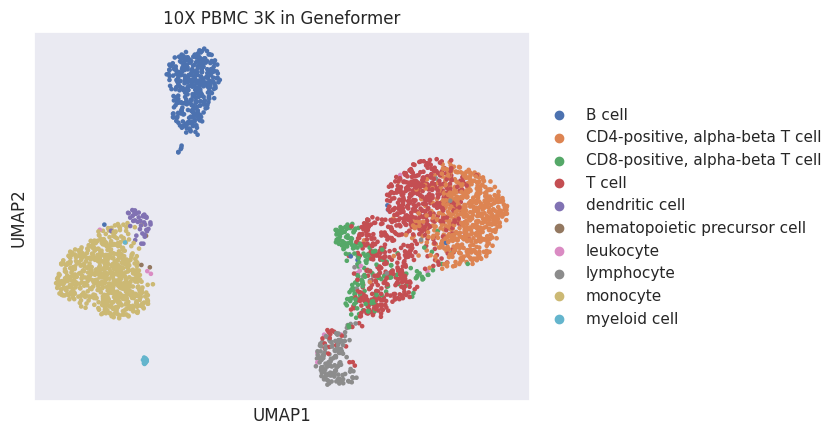

In [23]:
sc.pl.umap(adata, color="predicted_cell_subclass", title="10X PBMC 3K in Geneformer")

### Joining Geneformer embeddings from 10X PBMC 3K data with other Census datasets

There are multiple datasets in Census from PBMCs, and all human Census data has pre-calculated Geneformer embeddings, so now we can join the embeddings we generated above from the 10X PBMC 3K dataset with Census data.

Let's grab a few PBMC datasets from Census and request the Geneformer embeddings.

In [24]:
import cellxgene_census

In [25]:
# Some PBMC data from these collections
# 1. https://cellxgene.cziscience.com/collections/c697eaaf-a3be-4251-b036-5f9052179e70
# 2. https://cellxgene.cziscience.com/collections/f2a488bf-782f-4c20-a8e5-cb34d48c1f7e

dataset_ids = [
    "fa8605cf-f27e-44af-ac2a-476bee4410d3",
    "3c75a463-6a87-4132-83a8-c3002624394d",
]

with cellxgene_census.open_soma(census_version="2023-12-15") as census:

    adata_census = cellxgene_census.get_anndata(
        census=census,
        measurement_name="RNA",
        organism="Homo sapiens",
        obs_value_filter=f"dataset_id in {dataset_ids}",
        obs_embeddings=["geneformer"],
  )

To simplify let's select the genes that are also present in the 10X PBMC 3K dataset.

In [26]:
adata_census.var_names = adata_census.var["feature_id"]
shared_genes = list(set(adata.var_names) & set(adata_census.var_names))
adata_census = adata_census[:, shared_genes]

And take a subset of these cells, let's take 3K cells to match the size of the test data.

In [27]:
index_subset = np.random.choice(adata_census.n_obs, size=3000, replace=False)
adata_census = adata_census[index_subset, :]

Now we can join these Census data to the 10X PBMC 3K data

In [28]:
adata_census.obs["dataset"] = "Census - " + adata_census.obs["dataset_id"].astype(str)
adata.obs["dataset"] = "10X PBMC 3K"
adata.obs["cell_type"] = "Predicted - " + adata.obs["predicted_cell_subclass"].astype(str)

adata_joined = sc.concat([adata, adata_census], join="outer", label="batch")

Let's now inspect all of the cells in the UMAP space.

In [29]:
sc.pp.neighbors(adata_joined, n_neighbors=10, n_pcs=40, use_rep="geneformer")
sc.tl.umap(adata_joined)

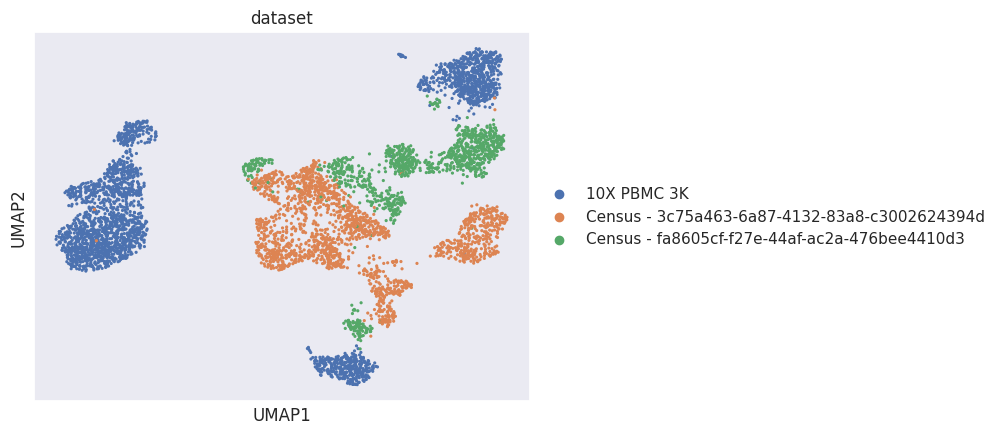

In [30]:
sc.pl.umap(adata_joined, color="dataset")

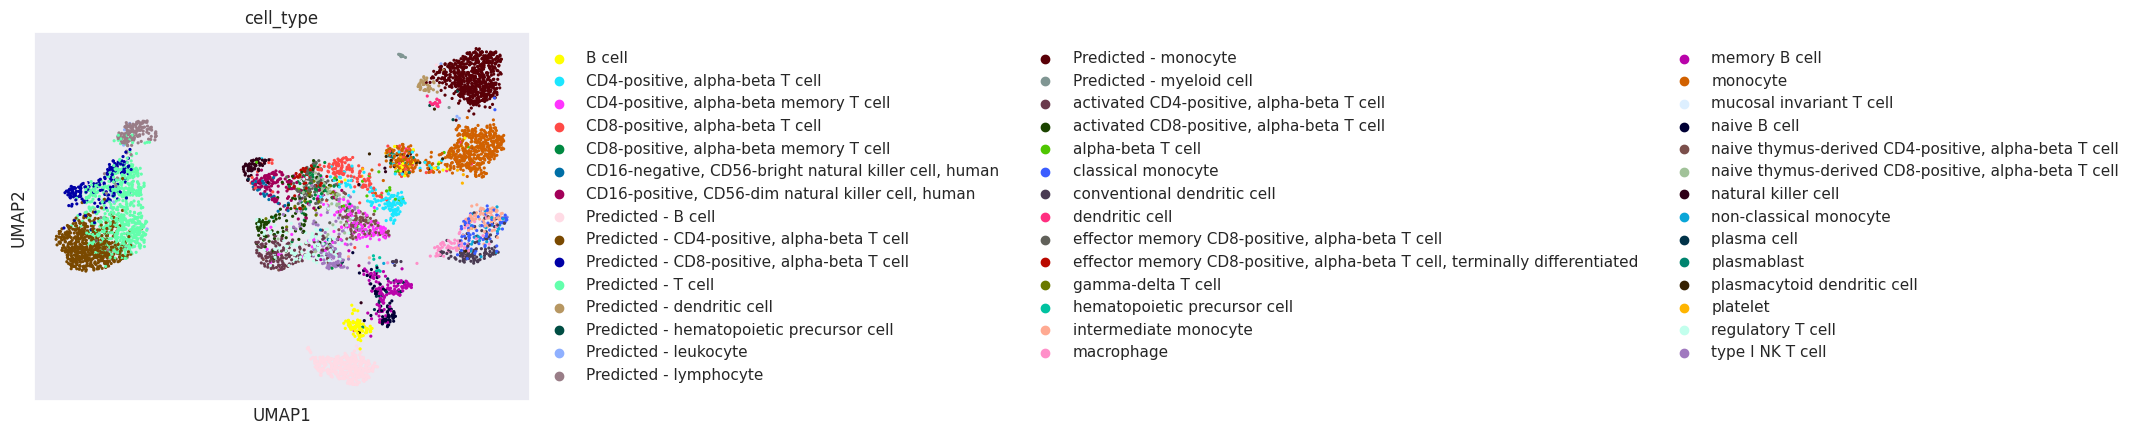

In [31]:
sc.pl.umap(adata_joined, color="cell_type")